# Capture + sequencing combined process simulation

This notebook is aimed at simulating a two stage dropout process where sequences are captured, then sequenced. We would like to demonstrate that these two processes can be summarized in a single capture process.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy.api as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time

/home/mkim7/anaconda3/envs/single_cell/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning


In [4]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'figure.titlesize':'xx-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)


### Hypergeometric vs binomial simulation

In [108]:
N = 2000
q = 0.1
true_value = 3

hyper = stats.hypergeom.rvs(N, true_value, int(N*q), size=100000)
binom = stats.binom.rvs(true_value, q, size=100000)

In [109]:
hyper.mean()

0.30102

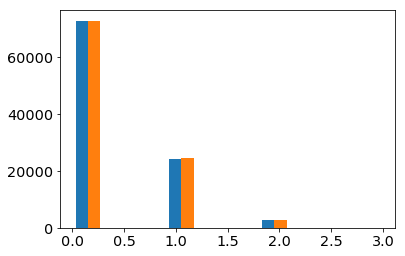

In [110]:
plt.hist([hyper, binom]);

### Function for simulating transcriptomes based on NB distributions

In [60]:
def convert_params(mu, theta):
    """
    Convert mean/dispersion parameterization of a negative binomial to the ones scipy supports

    See https://en.wikipedia.org/wiki/Negative_binomial_distribution#Alternative_formulations
    """
    r = theta
    var = mu + 1 / r * mu ** 2
    p = (var - mu) / var
    return r, 1 - p

def simulate_transcriptomes(n_cells, n_genes):
    
    gene_means = stats.lognorm.rvs(s=1, scale=15, size=n_genes)
    gene_dispersions = stats.lognorm.rvs(s=.7, scale=0.1, size=n_genes) # Larger means more variance
    gene_theta = 1/gene_dispersions

    return gene_means, gene_dispersions, stats.nbinom.rvs(*convert_params(gene_means, gene_theta), size=(n_cells, n_genes))

### Functions for sampling

In [61]:
def capture_sampling(transcriptomes, q, q_sq):
    
    m = q
    v = q_sq - q**2
    alpha = m*(m*(1-m)/v - 1)
    beta = (1-m)*(m*(1-m)/v - 1)
    print(alpha, beta)
    qs = stats.beta.rvs(alpha, beta, size=transcriptomes.shape[0])
    print(qs.mean())
    
    captured_transcriptomes = []
    for i in range(transcriptomes.shape[0]):
        captured_transcriptomes.append(
            stats.hypergeom.rvs(transcriptomes[i, :].sum(), transcriptomes[i, :], np.round(qs[i]*transcriptomes[i, :].sum()).astype(int))
        )
    
    return np.vstack(captured_transcriptomes)


def sequencing_sampling(transcriptomes):
    
    observed_transcriptomes = np.zeros(transcriptomes.shape)
    num_molecules = transcriptomes.sum()
    print(num_molecules)
    
    for i in range(n_cells):
        for j in range(n_genes):
            
            observed_transcriptomes[i, j] = (stats.binom.rvs(n=int(num_reads), p=1/num_molecules, size=transcriptomes[i, j]) > 0).sum()
            
    return observed_transcriptomes


### Define simulation parameters

In [62]:
n_cells = 5000
n_genes = 1000
q = 0.1
noise_level = 0.2049755522580501
q_sq = (noise_level+1)*q**2
num_reads = 2000000
sequencing_capture_efficiency = 0.5

### Run the simulation

In [63]:
_, _, transcriptome = simulate_transcriptomes(n_cells, n_genes)

In [64]:
q_sq

0.012049755522580504

In [65]:
captured_transcriptome = capture_sampling(transcriptome, q, q_sq)

4.290767533422531 38.61690780080278
0.1006022677070759


In [66]:
observed_transcriptome = stats.binom.rvs(captured_transcriptome, p=sequencing_capture_efficiency)

### Estimate overall noise parameters

In [67]:
observed_means = observed_transcriptome.mean(axis=0)
observed_vars = observed_transcriptome.var(axis=0)
observed_cv_sq = observed_vars/observed_means**2

Text(0, 0.5, 'log( observed CV^2 )')

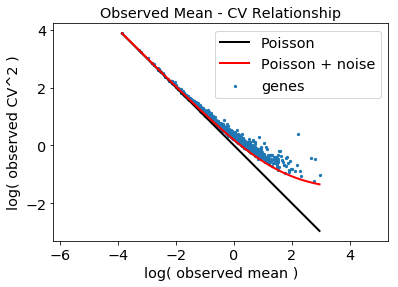

In [68]:
x = observed_means
y = observed_vars
estimated_noise_level = np.percentile(
    (y/x**2 - 1/x)[y > x], 
    q=6)
overall_q = observed_transcriptome.sum()/captured_transcriptome.sum() * q
overall_q_sq = (estimated_noise_level + 1)*overall_q**2

plt.scatter(
    np.log(observed_means),
    np.log(observed_cv_sq),
    s=5
)
bound_x = np.arange(
    np.nanmin(observed_means),
    np.nanmax(observed_means),
    0.01)
bound_y = 1/bound_x + estimated_noise_level

plt.plot(np.log(bound_x), -np.log(bound_x), color='k', lw=2)
plt.plot(np.log(bound_x), np.log(bound_y), lw=2, color='r')
plt.axis('equal');
plt.legend(['Poisson', 'Poisson + noise', 'genes'])
plt.title('Observed Mean - CV Relationship');
plt.xlabel('log( observed mean )')
plt.ylabel('log( observed CV^2 )')

In [69]:
overall_q_sq

0.003020816824074878

In [70]:
overall_q

0.050009090642550526

### Perform a single step of dropout

In [73]:
transcriptome.shape

(5000, 1000)

4.519727150925266 85.85838396552903
0.04998804605991748


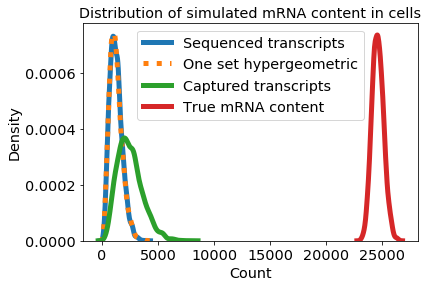

In [74]:
approx_observed_transcriptome = capture_sampling(transcriptome, overall_q, overall_q_sq)
sns.distplot(observed_transcriptome.sum(axis=1), hist=False, label='Sequenced transcripts', kde_kws={'lw':5})
sns.distplot(approx_observed_transcriptome.sum(axis=1), hist=False, label='One set hypergeometric', kde_kws={'lw':5, 'linestyle':':'})
sns.distplot(captured_transcriptome.sum(axis=1), hist=False, label='Captured transcripts', kde_kws={'lw':5})
sns.distplot(transcriptome.sum(axis=1), hist=False, label='True mRNA content', kde_kws={'lw':5})

plt.title('Distribution of simulated mRNA content in cells')
plt.xlabel('Count');plt.ylabel('Density')
plt.savefig('capture_seq_rna_content.pdf', bbox_inches='tight');
#sns.distplot(transcriptome.sum(axis=1))